In [3]:
import gymnasium as gym
import numpy as np

In [4]:
env = gym.make('CartPole-v1')
env.reset()
ss = env.observation_space.sample()
print(ss)



[ 1.1471303   0.34327912  0.1446895  -0.7883356 ]


-4.799983
-4.188088
-0.41887757
-4.564538


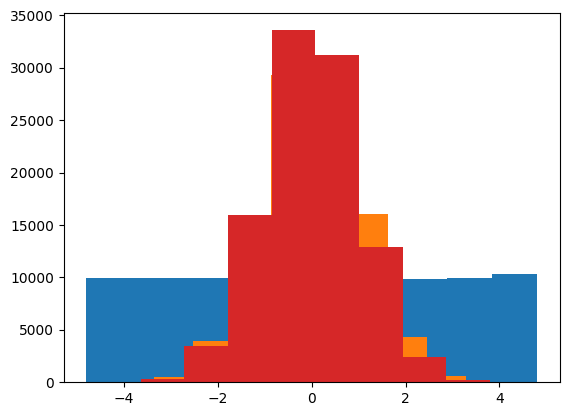

In [5]:
import matplotlib.pyplot as plt

total_obs = []
for i in range(100000):
    sample = env.observation_space.sample()
    total_obs.append(sample)

total_obs = np.array(total_obs)
plt.hist(total_obs[:,0]) # cart position
plt.hist(total_obs[:,1]) # cart velocity
plt.hist(total_obs[:,2]) # pole angle
plt.hist(total_obs[:,3]) # pole angular velocity

print(np.min(total_obs[:,0]))
print(np.min(total_obs[:,1]))
print(np.min(total_obs[:,2]))
print(np.min(total_obs[:,3]))


(array([17789., 17321.,  5008.,  4987.,  4923.,  5130.,  4915.,  4978.,
        17187., 17762.]),
 array([  0. ,  62.4, 124.8, 187.2, 249.6, 312. , 374.4, 436.8, 499.2,
        561.6, 624. ]),
 <BarContainer object of 10 artists>)

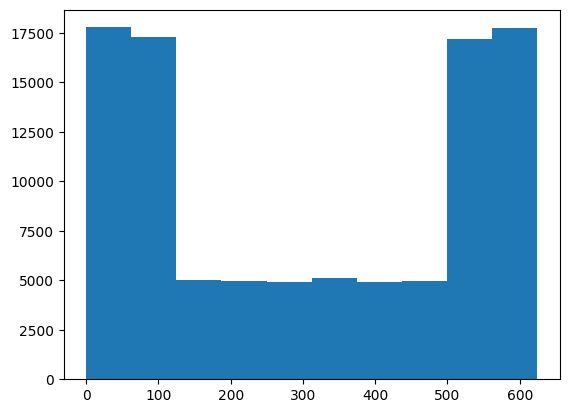

In [46]:
# hyperparameters
num_episodes = 20000
num_actions = 2
state_vars = 4
bins = 5
num_states = 5**state_vars
Q = np.zeros((num_states, num_actions))
gamma = 0.999
alpha = 0.2
epsilon = 1.0
epsilon_min = 0
decay_factor = 0.999 # use exponential decay

num_bins = 5
total_reward = 0

def discretize(s):
    def clamp(low, high, val):
        return min(high, max(low, val))

    # Define ranges
    pos_range, vel_range, ang_range, ang_vel_range = 2.4, 3.0, 0.209, 3.0

    # Clip inputs
    position = clamp(-pos_range, pos_range, s[0])
    velocity = clamp(-vel_range, vel_range, s[1])
    angle    = clamp(-ang_range, ang_range, s[2])
    angular_velocity = clamp(-ang_vel_range, ang_vel_range, s[3])

    # Calculate bin index (0 to num_bins) for each dimension
    # Using num_bins (5) in scaling
    pos_bin_raw = int((position + pos_range) / (2 * pos_range) * num_bins)
    vel_bin_raw = int((velocity + vel_range) / (2 * vel_range) * num_bins)
    ang_bin_raw = int((angle    + ang_range) / (2 * ang_range) * num_bins)
    ang_vel_bin_raw = int((angular_velocity + ang_vel_range) / (2 * ang_vel_range) * num_bins)

    # --- Add Clamping for Edge Cases ---
    # Ensure indices are between 0 and num_bins-1 (e.g., 0 and 4)
    pos_bin = min(pos_bin_raw, num_bins - 1)
    vel_bin = min(vel_bin_raw, num_bins - 1)
    ang_bin = min(ang_bin_raw, num_bins - 1)
    ang_vel_bin = min(ang_vel_bin_raw, num_bins - 1)
    # ----------------------------------

    # Combine using base-5 multipliers (125, 25, 5, 1)
    index = pos_bin * (num_bins**3) + vel_bin * (num_bins**2) + ang_bin * (num_bins**1) + ang_vel_bin * (num_bins**0)

    # Final safety clamp (shouldn't be needed if above is correct, but doesn't hurt)
    index = max(0, min(index, num_states - 1)) # num_states is 625 here

    return index

total_obs = []
for i in range(100000):
    sample = env.observation_space.sample()
    total_obs.append(discretize(sample))

total_obs = np.array(total_obs)
plt.hist(total_obs) # cart position

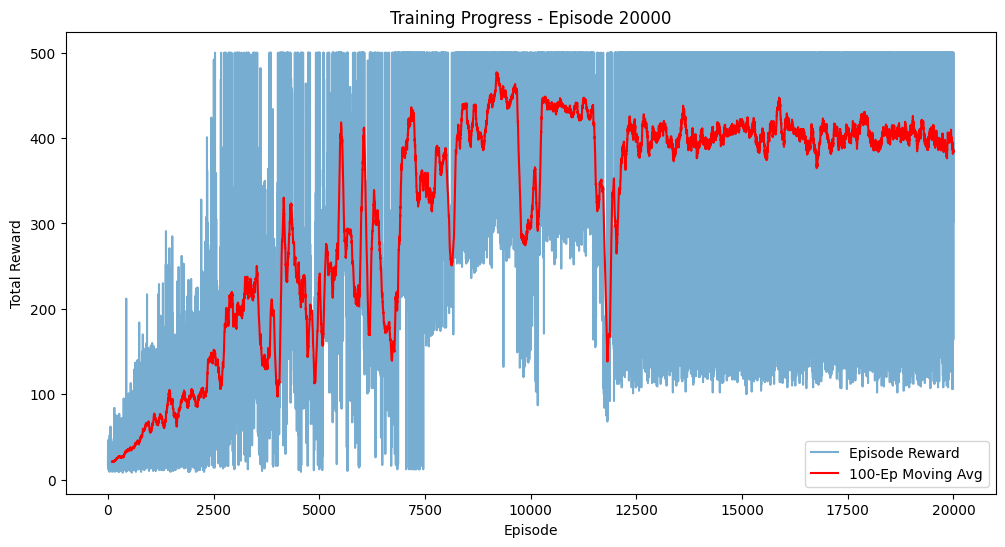

100%|██████████| 20000/20000 [02:15<00:00, 147.29it/s]


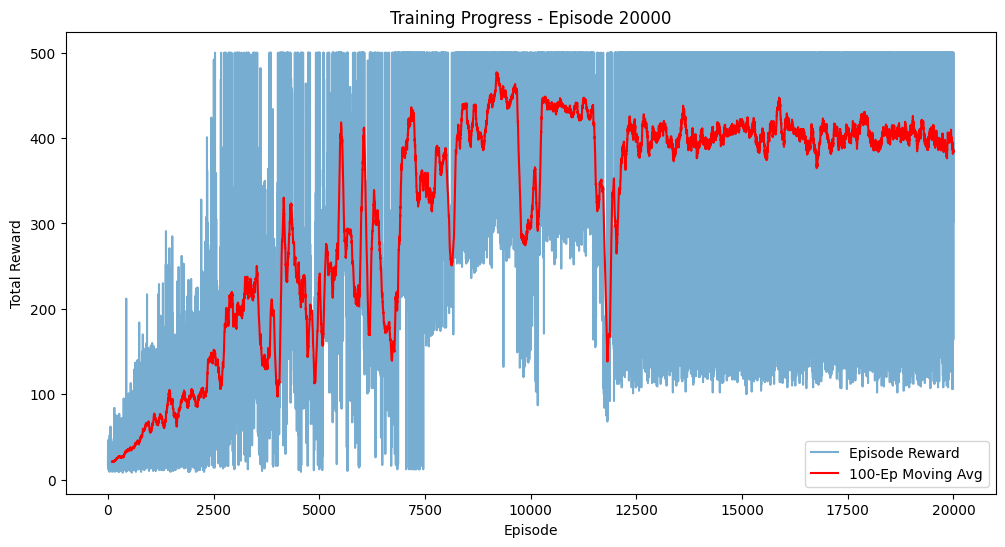

In [44]:
from tqdm import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from IPython.display import display, clear_output

# hyperparameters
num_episodes = 20000
num_actions = 2
state_vars = 4
bins = 5
num_states = 5**state_vars
Q = np.zeros((num_states, num_actions))
gamma = 0.999
alpha = 0.2
epsilon = 1.0
epsilon_min = 0
decay_factor = 0.999 # use exponential decay

num_bins = 5
total_reward = 0

def discretize(s):
    def clamp(low, high, val):
        return min(high, max(low, val))

    # Define ranges
    pos_range, vel_range, ang_range, ang_vel_range = 2.4, 3.0, 0.209, 3.0

    # Clip inputs
    position = clamp(-pos_range, pos_range, s[0])
    velocity = clamp(-vel_range, vel_range, s[1])
    angle    = clamp(-ang_range, ang_range, s[2])
    angular_velocity = clamp(-ang_vel_range, ang_vel_range, s[3])

    # Calculate bin index (0 to num_bins) for each dimension
    # Using num_bins (5) in scaling
    pos_bin_raw = int((position + pos_range) / (2 * pos_range) * num_bins)
    vel_bin_raw = int((velocity + vel_range) / (2 * vel_range) * num_bins)
    ang_bin_raw = int((angle    + ang_range) / (2 * ang_range) * num_bins)
    ang_vel_bin_raw = int((angular_velocity + ang_vel_range) / (2 * ang_vel_range) * num_bins)

    # --- Add Clamping for Edge Cases ---
    # Ensure indices are between 0 and num_bins-1 (e.g., 0 and 4)
    pos_bin = min(pos_bin_raw, num_bins - 1)
    vel_bin = min(vel_bin_raw, num_bins - 1)
    ang_bin = min(ang_bin_raw, num_bins - 1)
    ang_vel_bin = min(ang_vel_bin_raw, num_bins - 1)
    # ----------------------------------

    # Combine using base-5 multipliers (125, 25, 5, 1)
    index = pos_bin * (num_bins**3) + vel_bin * (num_bins**2) + ang_bin * (num_bins**1) + ang_vel_bin * (num_bins**0)

    # Final safety clamp (shouldn't be needed if above is correct, but doesn't hurt)
    index = max(0, min(index, num_states - 1)) # num_states is 625 here

    return index

def get_next_step(Q, s, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[s])

def update_q(Q, s, a, reward, gamma, alpha, s_p, done):
    if done:
        target = reward
    else:
        target = reward + gamma * np.max(Q[s_p])
    td_error = target - Q[s,a] 
    Q[s,a] = Q[s,a] + alpha * td_error

training_period = num_episodes / 10
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="training",
                  episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env, buffer_length=num_episodes)

# --- Plotting Setup ---
moving_avg_window = 100 # Adjust as needed
update_plot_every = 100 # Adjust as needed
fig, ax = plt.subplots(figsize=(12, 6))

# --- Data Storage for Plotting ---
all_episode_rewards = [] # Use your own list to store ALL rewards

for episode in tqdm(range(num_episodes)):
    obs, info  = env.reset()
    done = False

    while not done:
        step = get_next_step(Q, discretize(obs), epsilon)

        # retrieve new observation from environment
        next_obs, reward, terminated, truncated, info = env.step(step)
        if 'episode' in info:
            episode_return = info['episode']['r']
            all_episode_rewards.append(episode_return)

        if terminated or truncated:
            done = True
            
        # update Q function estimate
        update_q(Q, discretize(obs), step, reward, gamma, alpha, discretize(next_obs), done)
            
        obs = next_obs

    epsilon = max(epsilon_min, epsilon * decay_factor)
    if episode % (num_episodes / 10) == 0:
        print (f"episode-{episode} max reward to this point {np.max(env.return_queue)}")

    # --- Update Plot Periodically (using your FULL list) ---
    if (episode + 1) % update_plot_every == 0 and len(all_episode_rewards) > 0:
        clear_output(wait=True) # Clear previous output
        ax.cla() # Clear axes for fresh plot

        # Replot data
        ax.plot(all_episode_rewards, label='Episode Reward', alpha=0.6)
        if len(all_episode_rewards) >= moving_avg_window:
            moving_avg = np.convolve(all_episode_rewards, np.ones(moving_avg_window)/moving_avg_window, mode='valid')
            ax.plot(np.arange(moving_avg_window - 1, len(all_episode_rewards)), moving_avg, label=f'{moving_avg_window}-Ep Moving Avg', color='red')

        # Reset labels and title
        ax.set_xlabel("Episode")
        ax.set_ylabel("Total Reward")
        ax.set_title(f"Training Progress - Episode {episode + 1}")
        ax.legend()

        # Display the updated figure in the cell output
        display(fig)

env.close()

Episode time taken: deque([0.025836, 0.000461, 0.000348, 0.000147, 0.000137, 0.000234, 0.000244, 0.000317, 0.00028, 0.000156, 0.000303, 0.000119, 0.000548, 0.000346, 0.000132, 0.000371, 0.000222, 0.00022, 0.000464, 0.000193, 0.000295, 0.000174, 0.000478, 0.000191, 0.000375, 0.000259, 0.000129, 0.000134, 0.000324, 0.00042, 0.000385, 0.000166, 0.000215, 0.000374, 0.000353, 0.000142, 0.000373, 0.000274, 0.000275, 0.000105, 0.000275, 0.000179, 0.000238, 0.000142, 0.000278, 0.000158, 0.000377, 0.000614, 0.000539, 0.000179, 0.000254, 0.000482, 0.000196, 0.00029, 0.000262, 0.000651, 0.000164, 0.000215, 0.001028, 0.000211, 0.000272, 0.000187, 0.000174, 0.00056, 0.00021, 0.00021, 0.000153, 0.000719, 0.000221, 0.000345, 0.000125, 0.000155, 0.000162, 0.00059, 0.000187, 0.000151, 0.00044, 0.000162, 0.000174, 0.000351, 0.000114, 0.000223, 0.000383, 0.000271, 0.000459, 0.00021, 0.000477, 0.000198, 0.000562, 0.000568, 0.00017, 0.000126, 0.000213, 0.000526, 0.000138, 0.000238, 0.000296, 0.000417, 0.00

50000

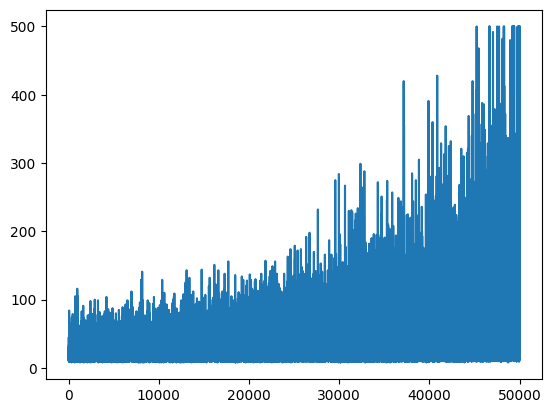

In [28]:
np.max(Q)

# plt.plot(total_rewards)

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')
plt.plot(env.return_queue)

len(env.return_queue)